# Data Curation
To train a machine learning model from data, that data must first be "curated" to ensure that chemical structures 
and properties are represented consistently.
Curating raw data is a long, detailed process that takes several steps.
[SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) strings need to be standardized, measurements
need to be converted to common units, outliers need to be removed or corrected, 
and replicates need to be combined. These steps are vital to create datasets that
can be used to train useful predictive models. 
Here we will cover some functions in [AMPL](https://github.com/ATOMScience-org/AMPL) that will help
you to perform these steps.

- [base_smiles_from_smiles](https://ampl.readthedocs.io/en/latest/utils.html#utils.struct_utils.base_smiles_from_smiles)
- [standardize_relations](https://ampl.readthedocs.io/en/latest/utils.html#utils.data_curation_functions.standardize_relations)
- [compute_negative_log_responses](https://ampl.readthedocs.io/en/latest/utils.html#utils.data_curation_functions.compute_negative_log_responses)
- [remove_outlier_replicates](https://ampl.readthedocs.io/en/latest/utils.html#utils.curate_data.remove_outlier_replicates)
- [aggregate_assay_data](https://ampl.readthedocs.io/en/latest/utils.html#utils.curate_data.aggregate_assay_data)

These are just a few of the steps needed to curate a dataset;
another tutorial will cover data curation in more detail.

## Import Standard Data Science Packages
To use [AMPL](https://github.com/ATOMScience-org/AMPL), or to do almost anything else with data, you'll need to become familiar with the popular packages 
[pandas](https://pandas.pydata.org/), 
[numpy](https://numpy.org/), 
[matplotlib](https://matplotlib.org/) and 
[seaborn](https://seaborn.pydata.org/index.html). 
When you installed AMPL you will have installed these packages as well, so you simply need to import them here.

In [ ]:
#!conda install --yes openpyxl 
#!conda install --yes xlrd

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
# Set for less chatty log messages
import logging

logger = logging.getLogger('ATOM')
logger.setLevel(logging.INFO)
# ignore sklearn future warnings
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

from atomsci.ddm.pipeline import predict_from_model as pfm
from sklearn.metrics import r2_score

In [ ]:
print(4)

## Read the Data
We've prepared an example dataset containing [$IC_{50}$](https://en.wikipedia.org/wiki/IC50) values for inhibitors of 
the [KCNA3](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL4633/) 
potassium channel collected from [ChEMBL](https://www.ebi.ac.uk/chembl/). This dataset is 
simpler than most that we find in the wild, but it will let us concisely 
demonstrate some AMPL curation tools. The first step of data curation is to read the dataset into a Pandas data frame.

In [3]:
# excel file with the logP dataset
#logP = pd.DataFrame(pd.read_excel('dataset/Dataset_and_Predictions.xlsx')) 
logP = pd.read_csv('dataset/Dataset_and_Predictions.csv')
logP

,SMILES,CAS,ChemID,logP\nexperimental\n(corrected),logP\npredicted,DNNtaut,DNNmono,KOWWIN,OCHEM,ALOGPS,...,assignments,original SMILES,original SMILES\nwithout ions\n,original SMILES randomly selected (including tautomers),original SMILES most likely tautomer,SMILES randomly selected,SMILES randomly selected without ions,canonical SMILES,SMILES including explicit H atoms,classified as ion?
0,CCC1(NC(=O)N(C)C1=O)c1ccccc1,50-12-4,100008,1.69,NaN,2.04,2.08,1.65,1.61,1.64,...,NaN,test,test,test,none,none,none,test,none,no
1,[H]N1C(=O)N(C(=O)C1(C1=C([H])C([H])=C([H])C([H...,50-12-4,100008,1.69,NaN,1.97,1.16,1.65,1.61,1.64,...,NaN,none,none,none,none,none,none,none,test,no
2,CCC1(NC(=O)N(C)C1=O)C1=CC=CC=C1,50-12-4,100008,1.69,NaN,2.04,2.08,1.65,1.61,1.64,...,NaN,none,none,none,test,none,none,none,none,no
3,[H]OC1=NC(C(=O)N1C([H])([H])[H])(C1=C([H])C([H...,50-12-4,100008,1.69,NaN,1.71,1.26,1.05,1.25,1.43,...,NaN,none,none,none,none,test,test,none,none,no
4,CCC1(N=C(O)N(C)C1=O)C1=CC=CC=C1,50-12-4,100008,1.69,NaN,1.71,1.94,1.05,1.25,1.43,...,NaN,none,none,none,none,none,none,none,none,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12704,S=C(NN=C(c1ccccn1)c1ccccn1)Nc1ccccc1,67629-66-7,115633,1.96,NaN,2.82,3.13,4.24,2.76,3.42,...,NaN,test,test,none,none,none,none,none,none,no
12705,S=C(NN=C(c1ccccn1)c2ccccn2)Nc3ccccc3,67629-66-7,115633,1.96,NaN,2.82,3.13,4.24,2.76,3.42,...,NaN,none,none,none,none,none,none,none,none,no
12706,[H]SC(N=NC([H])(C1=C([H])C([H])=C([H])C([H])=N...,67629-66-7,115633,1.96,NaN,2.69,2.34,4.91,3.22,4.24,...,NaN,none,none,none,none,none,none,none,none,no
12707,[H]N(C(=S)N=NC([H])(C1=C([H])C([H])=C([H])C([H...,67629-66-7,115633,1.96,NaN,2.63,2.22,5.48,3.43,4.39,...,NaN,none,none,none,none,none,none,none,none,no


In [4]:
# Check the number of rows and columns in the dataset
logP.shape

(12709, 24)

In [5]:
# List the column names
logP.columns.values

array(['SMILES', 'CAS', 'ChemID', 'logP\nexperimental\n(corrected)',
       'logP\npredicted', 'DNNtaut', 'DNNmono', 'KOWWIN', 'OCHEM',
       'ALOGPS', 'JChem', 'DataWarrior', 'ACD GALAS',
       'COSMO-RS (tautomers not considered)', 'assignments',
       'original SMILES', 'original SMILES\nwithout ions\n',
       'original SMILES randomly selected (including tautomers)',
       'original SMILES most likely tautomer', 'SMILES randomly selected',
       'SMILES randomly selected without ions', 'canonical SMILES',
       'SMILES including explicit H atoms', 'classified as ion?'],
      dtype=object)

In [6]:
type(logP["ChemID"][0])

numpy.int64

In [7]:
len(logP["ChemID"].unique())

1389

This dataset is drawn from Mansouri et al. and contains these following columns:
- `ChemID`: The ChEMBL ID for the molecule.
- `CAS`: CAS registry number unique for each chemical substance
- `SMILES`: The SMILES string that represents the molecule's structure. This is the main
input used to derive features for [AMPL](https://github.com/ATOMScience-org/AMPL) models.
- `logP\nexperimental\n(corrected)`: contains all the corrected values of logP for the molecules
- `DNNtaut`: predicted logP using DNN with data augmentation
- `DNNmono`: predicted logP using DNN without data augmentation
- `KOWWIN` : predicted logP using Meylan/Kowwin  model 
- `OCHEM` : predicted logP using OCHEM model


This dataset is drawn from the ChEMBL database and contains the following columns:
- `molecule_chembl_id`: The ChEMBL ID for the molecule.
- `smiles`: The SMILES string that represents the molecule's structure. This is the main
input used to derive features for [AMPL](https://github.com/ATOMScience-org/AMPL) models.
- `standard_type`: The type of measurement, e.g., $IC_{50}$, $K_i$, $K_d$, etc.
This dataset only contains $IC_{50}$ data points.
- `standard_relation`: The relational operator for a measurement reported as "< $X$" or "> $X$", indicating the true value is below or above some limit $X$ (e.g., the lowest or highest concentration tested). When this occurs we say the measurement is "left-" or "right-censored".
- `standard_value`: The measured value (or the limit value for a censored measurement).
- `standard_units`: The units of the measurement. $IC_{50}$ values may be recorded in different units which will need to be converted to a common unit. The KCNA3 dataset uses nanomolar (nM) units exclusively, but other datasets we'll work with may contain a mixture of nanomolar and micromolar (µM or uM) units.

## Standardize SMILES
The SMILES grammar allows the same chemical structure to be represented by many different SMILES strings. In addition, measurements may be performed on compounds with different salt groups or with radioisotope labels, which we treat as equivalent to the base compounds. AMPL provides a SMILES standardization function, `base_smiles_to_smiles`, that removes salt groups and isotopes and returns a unique SMILES string for each base compound structure. This step simplifies the machine learning problem by ensuring each compound is represented with the same set of features and multiple measurements on the same compound can be grouped together. 

> **Note:** *The input to base_smiles_from_smiles must be a `list`; `numpy` arrays and `pandas` Series objects must be converted with the `tolist` function.*

In [8]:
from atomsci.ddm.utils.struct_utils import base_smiles_from_smiles
# Since the base_smiles_from_smiles function can be slow, we specify the workers=8 argument
# to divide the work across 8threads.
logP['base_rdkit_smiles'] = base_smiles_from_smiles(logP.SMILES.tolist(), workers=8)

In [9]:
logP.SMILES.nunique(), logP.base_rdkit_smiles.nunique()

(12709, 5523)

In [10]:
unique_logP = logP.drop_duplicates(subset=['ChemID']) # manually drop because base smiles function is not working

In [ ]:
#unique_logP["ChemID"] = "CHEMBL" + unique_logP["ChemID"].astype(str)  # manually drop because base smiles function is not working

In [11]:
unique_logP.loc[:,"ChemID"] = "CHEMBL" + unique_logP["ChemID"].astype(str)  # manually drop because base smiles function is not working

In [12]:
unique_logP

,SMILES,CAS,ChemID,logP\nexperimental\n(corrected),logP\npredicted,DNNtaut,DNNmono,KOWWIN,OCHEM,ALOGPS,...,original SMILES,original SMILES\nwithout ions\n,original SMILES randomly selected (including tautomers),original SMILES most likely tautomer,SMILES randomly selected,SMILES randomly selected without ions,canonical SMILES,SMILES including explicit H atoms,classified as ion?,base_rdkit_smiles
0,CCC1(NC(=O)N(C)C1=O)c1ccccc1,50-12-4,CHEMBL100008,1.69,NaN,2.04,2.08,1.65,1.61,1.64,...,test,test,test,none,none,none,test,none,no,CCC1(c2ccccc2)NC(=O)N(C)C1=O
5,CCN(CC)C(O)=C1CN(C)[C@@H]2CC3=CNC4=CC=CC(=C34)...,50-37-3,CHEMBL100022,2.95,NaN,2.15,3.24,2.31,2.85,2.97,...,none,none,test,none,none,none,none,none,no,CCN(CC)C(O)=C1C=C2c3cccc4[nH]cc(c34)C[C@H]2N(C)C1
17,O[C@H](CO)[C@@H](O)[C@H](O)[C@@H](O)CO,50-70-4|69-65-8|608-66-2,CHEMBL100032,-2.80,NaN,-2.65,-2.30,-3.01,-2.64,-2.77,...,test,test,test,none,none,none,none,none,no,OC[C@@H](O)[C@@H](O)[C@H](O)[C@@H](O)CO
22,OC[C@H](O)[C@H]1OC(=O)C(=O)C1O,50-81-7,CHEMBL100036,-1.85,NaN,-2.28,-1.93,-3.55,-1.54,-1.78,...,none,none,test,test,none,none,none,none,no,O=C1O[C@H]([C@@H](O)CO)C(O)C1=O
37,Cc1ccc(C(O)=O)c(O)c1,50-85-1,CHEMBL100037,2.99,NaN,2.68,2.05,2.79,2.39,2.40,...,none,none,test,none,none,none,none,none,yes,Cc1ccc(C(=O)O)c(O)c1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12651,Oc1cc(O)c2CC(OCCC#N)C(Oc2c1)c1ccc(O)c(O)c1,NOCAS_875024,CHEMBL115612,0.96,NaN,1.17,0.78,1.39,1.18,2.08,...,test,test,test,none,none,none,none,none,no,N#CCCOC1Cc2c(O)cc(O)cc2OC1c1ccc(O)c(O)c1
12660,Oc1coc(CSc2ccccn2)cc1=O,NOCAS_876688,CHEMBL115616,1.14,NaN,0.93,0.77,0.83,1.05,1.52,...,test,test,test,none,none,none,none,none,no,O=c1cc(CSc2ccccn2)occ1O
12666,OC1=CC=CC2=C1C(=O)C1=C(O)C=CC=C1C2=CNC1=CC=CC=C1,NOCAS_878547,CHEMBL115626,4.96,NaN,4.79,4.57,4.96,4.92,3.96,...,none,none,test,test,none,none,none,none,no,O=C1c2c(O)cccc2C(=CNc2ccccc2)c2cccc(O)c21
12675,OC1=C(C2=CC=CC(=C2)N2C=CC3=CC=CC=C23)C(=O)C2=C...,NOCAS_878623,CHEMBL115629,5.53,NaN,4.96,4.60,4.64,5.40,5.10,...,none,none,test,none,none,none,none,none,no,O=C1C(c2cccc(-n3ccc4ccccc43)c2)=C(O)[N]c2cc(Cl...


For this dataset there are 515 unique SMILES that are standardized to 515 unique base SMILES (though some differ from the originals). In other datasets it is common for two different SMILES to be standardized to the same value. From now on we will use `base_rdkit_smiles` to represent compound structures.

The AMPL function `compute_negative_log_responses` performs these variance stabilizing transformations, converting $IC_{50}$'s to $pIC_{50}$'s and so on. The code below uses the 
units in the `standard_units` column and the conversion functions specified 
in the `unit_conv` argument to convert the $IC_{50}$'s in the `standard_value` column to molar units before applying the log transformation. It also inverts the "<" and ">" operators in `relation_col` so that they correctly 
describe the $pIC_{50}$ values, which *decrease* as $IC_{50}$ values *increase* (e.g., "$IC_{50} > 100 \mathrm{uM}$" means "$IC_{50} > 10^{-4} \mathrm{M}$" which implies "$pIC_{50} < 4$").

In [13]:
from atomsci.ddm.utils.data_curation_functions import compute_negative_log_responses 
logP = compute_negative_log_responses(logP, 
                              unit_col='standard_units',
                              value_col='standard_value',
                              new_value_col='pIC50',
                              relation_col='standard_relation',
                              unit_conv={'µM':lambda x: x*1e-6, 'nM':lambda x: x*1e-9},
                              inplace=False)

KeyError: 'standard_units'

# Normally distributed?

logP values are already transformed

In [ ]:
_ = unique_logP['logP\nexperimental\n(corrected)'].hist()
plt.title("LogP Values are Approximately Normal")
plt.show()

In [ ]:
_ = logP['logP\nexperimental\n(corrected)'].hist()

In [ ]:
_ = logP[['DNNtaut','DNNmono']].hist(figsize=(8,4))

In [ ]:
_ = unique_logP[['logP\nexperimental\n(corrected)','DNNtaut','DNNmono']].hist()

In [ ]:
# cant plot KOWWIN, OCHEM, 
_ = logP[['logP\nexperimental\n(corrected)','KOWWIN', 'OCHEM',
       'ALOGPS', 'JChem', 'DataWarrior', 'ACD GALAS',
       'COSMO-RS (tautomers not considered)']].hist()

In [ ]:
logP[['classified as ion?']].value_counts().plot.bar()
plt.title("Almost 3000 Ions in Original Dataset")
plt.show()

In [ ]:
unique_logP[['classified as ion?']].value_counts().plot.bar()
plt.title("About 200 Unique Ions in Dataset")
plt.show()

## Standardize Relations
Some databases may contain measurements reported with a variety of relational operators such as ">=", "<=", "~" and so on. In datasets used to train models, AMPL expects the relation column to contain one of the three standard operators ">", "<" or "=", or an empty field representing equality. [AMPL](https://github.com/ATOMScience-org/AMPL) provides a `standardize_relations` function to coerce nonstandard relations to one of the standard values. We use the `rel_col` and `output_rel_col` arguments to indicate that the input relations are in the `standard_relation` column, and to specify a new column to receive the standardized relations.  The `db=ChEMBL` argument tells the function to apply ChEMBL-specific formatting changes (such as removing quotes around operators).

For this dataset, we see that there were no nonstandard operators, but the single quotes around the operators were removed, as we requested.

## Remove Outliers and Aggregate Replicate Measurements
The final step is to remove outliers and aggregate (average) replicate measurements on the same compounds. The function `remove_outlier_replicates` is a simple filter that groups measurements by compound, computes the median of each group, and removes values that differ more than `max_diff_from_median` units from the median. When the measurements are very spread out relative to `max_diff_from_median`, *all* the rows for a compound may be deleted from the dataset. The default setting (1.0) generally works well for $pIC_{50}$ values.

The function `aggregate_assay_data` replaces multiple replicate measurements for each compound with a single aggregate value. Usually this is simply the average over the replicates, but if the dataset contains both censored and uncensored values for a compound, the function computes a maximum likelihood estimate that takes the censoring into account.


> **Note** 
> When the `label_actives` argument is True (the default), an additional column `active` is added for use in training classification models. We will cover
classification models in a future tutorial.

Finally, we save the curated dataset to a CSV file. 

In [ ]:
#kcna3_cur.to_csv('dataset/curated_kcna3_ic50.csv', index=False)

In [14]:
# create a standard relation column for outlier removal
logP['fixed_relation'] = '='

# what values should be considered low, medium, high?

# What logP values should be considered "outliers" when compared to median? For pIC50 it was 1, but it seems logP has smaller values in general

In [15]:
from atomsci.ddm.utils.curate_data import remove_outlier_replicates, aggregate_assay_data

logP_cur = remove_outlier_replicates(logP, id_col='ChemID',
                                response_col='logP\nexperimental\n(corrected)',
                                max_diff_from_median=0.5)

logP_cur = aggregate_assay_data(logP_cur, 
                             value_col='logP\nexperimental\n(corrected)',
                             output_value_col='average_logP',
                             id_col='ChemID',
                             smiles_col='base_rdkit_smiles',
                             relation_col='fixed_relation',
                             label_actives=False,
                             verbose=True
                        )

print("Original data shape: ", logP.shape)
print("Curated data shape: ", logP_cur.shape)
logP_cur.head()

Removed 1 logP
experimental
(corrected) replicate measurements that were > 0.5 from median
0 entries in input table are missing SMILES strings


5523 unique SMILES strings are reduced to 5523 unique base SMILES strings
Original data shape:  (12709, 26)
Curated data shape:  (5523, 4)


,compound_id,base_rdkit_smiles,relation,average_logP
0,102422,BrC=C(Br)Br,,3.20
1,101049,Brc1ccc(Br)cc1,,3.79
2,107341,Brc1cccc(Oc2ccc(Br)c(Br)c2Br)c1,,6.05
3,103677,Brc1ccccc1-c1ccccc1,,4.59
4,100362,C#CC,,0.94


In [16]:
# create a standard relation column for outlier removal
unique_logP['fixed_relation'] = '='

/var/tmp/ipykernel_174624/789396568.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_logP['fixed_relation'] = '='


In [17]:
from atomsci.ddm.utils.curate_data import remove_outlier_replicates, aggregate_assay_data

logP_cur = remove_outlier_replicates(unique_logP, id_col='ChemID',
                                response_col='logP\nexperimental\n(corrected)',
                                max_diff_from_median=0.5)

logP_cur = aggregate_assay_data(logP_cur, 
                             value_col='logP\nexperimental\n(corrected)',
                             output_value_col='average_logP',
                             id_col='ChemID',
                             smiles_col='SMILES',
                             relation_col='fixed_relation',
                             label_actives=False,
                             verbose=True
                        )

print("Original data shape: ", logP.shape)
print("Curated data shape: ", logP_cur.shape)
logP_cur.head()

0 entries in input table are missing SMILES strings


1389 unique SMILES strings are reduced to 1389 unique base SMILES strings
Original data shape:  (12709, 26)
Curated data shape:  (1389, 4)


,compound_id,base_rdkit_smiles,relation,average_logP
0,CHEMBL102422,BrC=C(Br)Br,,3.20
1,CHEMBL101049,Brc1ccc(Br)cc1,,3.79
2,CHEMBL107341,Brc1cccc(Oc2ccc(Br)c(Br)c2Br)c1,,6.05
3,CHEMBL103677,Brc1ccccc1-c1ccccc1,,4.59
4,CHEMBL100362,C#CC,,0.94


In [18]:
#logP_cur["compound_id"]
logP_cur["compound_id"] = logP_cur['compound_id'].astype('object')

In [19]:
logP_cur["compound_id"]

0       CHEMBL102422
1       CHEMBL101049
2       CHEMBL107341
3       CHEMBL103677
4       CHEMBL100362
            ...     
1384    CHEMBL101649
1385    CHEMBL101775
1386    CHEMBL102028
1387    CHEMBL104361
1388    CHEMBL101716
Name: compound_id, Length: 1389, dtype: object

In [ ]:
# save file for dev/test split
#logP_cur.to_csv('dataset/curated_logP_classi.csv', index=False)

In [ ]:
# save file for dev/test split
#logP_cur.to_csv('dataset/curated_logP.csv', index=False)

In [ ]:
len(logP_cur["compound_id"].unique())

In [ ]:
len(logP_cur["base_rdkit_smiles"].unique())

# Train/test split

In [21]:
#'dataset/SLC6A3_Ki_curated.csv'
dataset_file = 'dataset/curated_logP.csv'
#dataset_file = 'dataset/curated_logPclass.csv'
odir = 'dataset'

# Set for less chatty log messages
import logging
logger = logging.getLogger('ATOM')
logger.setLevel(logging.INFO)

In [22]:
# regression params
params = {
    "verbose": "False",
    "system": "LC",

    # dataset info
    "dataset_key" : dataset_file,
    "datastore": "False",
    "response_cols" : "average_logP",
    "id_col": "compound_id",
    "smiles_col" : "base_rdkit_smiles",
    "result_dir": odir,

    # splitting
    "split_only": "True",
    "previously_split": "False",
    "splitter": 'scaffold',
    "split_valid_frac": "0.15",
    "split_test_frac": "0.15",

    # featurization & training params
    "featurizer": "computed_descriptors",
    "descriptor_type" : "rdkit_raw",
    "previously_featurized": "True",
}

In [23]:
params

{'verbose': 'False',
 'system': 'LC',
 'dataset_key': 'dataset/curated_logP.csv',
 'datastore': 'False',
 'response_cols': 'average_logP',
 'id_col': 'compound_id',
 'smiles_col': 'base_rdkit_smiles',
 'result_dir': 'dataset',
 'split_only': 'True',
 'previously_split': 'False',
 'splitter': 'scaffold',
 'split_valid_frac': '0.15',
 'split_test_frac': '0.15',
 'featurizer': 'computed_descriptors',
 'descriptor_type': 'rdkit_raw',
 'previously_featurized': 'True'}

In [24]:
pd.read_csv(dataset_file)[['compound_id','base_rdkit_smiles','average_logP']]

,compound_id,base_rdkit_smiles,average_logP
0,CHEMBL102422,BrC=C(Br)Br,3.20
1,CHEMBL101049,Brc1ccc(Br)cc1,3.79
2,CHEMBL107341,Brc1cccc(Oc2ccc(Br)c(Br)c2Br)c1,6.05
3,CHEMBL103677,Brc1ccccc1-c1ccccc1,4.59
4,CHEMBL100362,C#CC,0.94
...,...,...,...
1384,CHEMBL101649,c1ccc2cc3c(cc2c1)-c1cccc2cccc-3c12,6.11
1385,CHEMBL101775,c1cnc2nccnc2c1,-0.04
1386,CHEMBL102028,c1cncc([C@@H]2CCCCN2)c1,0.97
1387,CHEMBL104361,c1coc(C2=Nc3ccccc3[N]2)c1,2.67


In [25]:
from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse

pparams = parse.wrapper(params)
MP = mp.ModelPipeline(pparams)
split_uuid = MP.split_dataset()

INFO:ATOM:Using prefeaturized data; number of features = 200
INFO:ATOM:Splitting data by scaffold
INFO:ATOM:Dataset split table saved to /home/jupyter/AMPL/atomsci/logP/dataset/curated_logP_train_valid_test_scaffold_42e09469-feb8-4703-8fef-452692863d2a.csv


In [26]:
# display the split file location
import glob
import os
dirname = os.path.dirname(params['dataset_key'])
split_file = glob.glob(f"{dirname}/*{split_uuid}*")[0]
split_file

'dataset/curated_logP_train_valid_test_scaffold_42e09469-feb8-4703-8fef-452692863d2a.csv'

In [27]:
split_df = pd.read_csv(split_file)
split_df

,cmpd_id,subset,fold
0,CHEMBL106070,train,0
1,CHEMBL113671,train,0
2,CHEMBL100572,train,0
3,CHEMBL102727,train,0
4,CHEMBL102061,train,0
...,...,...,...
1384,CHEMBL108183,test,0
1385,CHEMBL113275,test,0
1386,CHEMBL100036,test,0
1387,CHEMBL102336,test,0


In [29]:
# Show the numbers of compounds in each split subset
split_df.subset.value_counts()

subset
train    972
test     209
valid    208
Name: count, dtype: int64

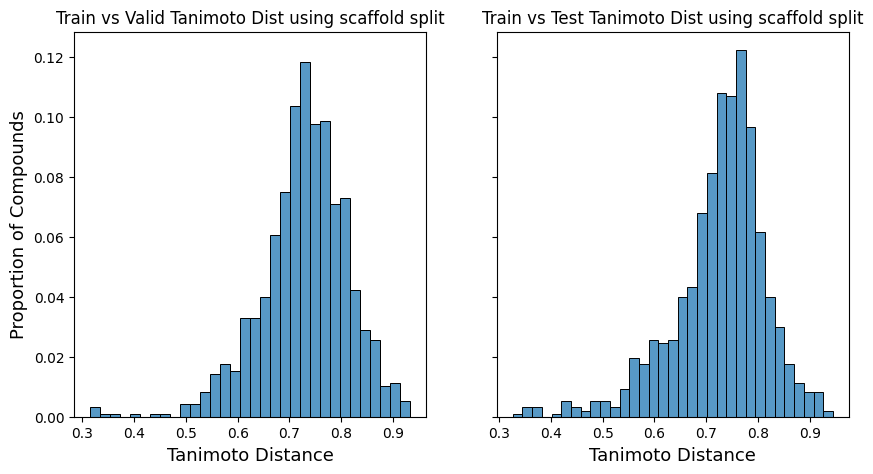

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import atomsci.ddm.utils.compare_splits_plots as csp

# read the dataset
df = pd.read_csv(dataset_file)

# read the split file
split = pd.read_csv(split_file)
split_type = params['splitter']

# create SplitStats
ss = csp.SplitStats(df, split, smiles_col='base_rdkit_smiles', id_col='compound_id', response_cols=['average_logP'])

# plot
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))
ss.dist_hist_train_v_valid_plot(ax=ax[0])
ax[0].set_title(f"Train vs Valid Tanimoto Dist using {split_type} split")
ss.dist_hist_train_v_test_plot(ax=ax[1])
ax[1].set_title(f"Train vs Test Tanimoto Dist using {split_type} split");

In [ ]:
# run if you want to use a random splitter instead
random_params = {
    "verbose": "False",
    "system": "LC",

    # dataset info
    "dataset_key" : dataset_file,
    "datastore": "False",
    "response_cols" : "average_logP",
    "id_col": "compound_id",
    "smiles_col" : "base_rdkit_smiles",
    "result_dir": odir,

    # splitting
    "split_only": "True",
    "previously_split": "False",
    "splitter": 'random',
    "split_valid_frac": "0.15",
    "split_test_frac": "0.15",

    # featurization & training params
    "featurizer": "computed_descriptors",
    "descriptor_type" : "rdkit_raw",
    "previously_featurized": "True",
}

In [ ]:
# do a random split instead

from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse

rparams = parse.wrapper(random_params)
rMP = mp.ModelPipeline(rparams)
rsplit_uuid = rMP.split_dataset()

In [ ]:
rdirname = os.path.dirname(random_params['dataset_key'])
rsplit_file = glob.glob(f"{rdirname}/*{rsplit_uuid}*")[0]
rsplit_file

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import atomsci.ddm.utils.compare_splits_plots as csp

# read the dataset
df = pd.read_csv(dataset_file)

# read the split file
rsplit = pd.read_csv(rsplit_file)
rsplit_type = random_params['splitter']

# create SplitStats
ss = csp.SplitStats(df, rsplit, smiles_col='base_rdkit_smiles', id_col='compound_id', response_cols=['average_logP'])

# plot
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))
ss.dist_hist_train_v_valid_plot(ax=ax[0])
ax[0].set_title(f"Train vs Valid Tanimoto Dist using {rsplit_type} split")
ss.dist_hist_train_v_test_plot(ax=ax[1])
ax[1].set_title(f"Train vs Test Tanimoto Dist using {rsplit_type} split");

In [ ]:
df['compound_id'] = df['compound_id'].astype('object')

In [ ]:
import atomsci.ddm.utils.split_response_dist_plots as srdp
split_params = {
    "dataset_key" : dataset_file,
    "smiles_col" : "base_rdkit_smiles",
    "response_cols" : "average_logP",
    "split_uuid": split_uuid,
    "splitter": 'scaffold',
}
srdp.plot_split_subset_response_distrs(split_params)

From the plots, we see that in this dataset, the logP's have roughly similar distributions across the scaffold split subsets, except that the validation set has slightly more compounds with varied logP values and the training set appears to have more outliers.

In [ ]:
import atomsci.ddm.utils.split_response_dist_plots as srdp
split_params = {
    "dataset_key" : dataset_file,
    "smiles_col" : "base_rdkit_smiles",
    "response_cols" : "average_logP",
    "split_uuid": rsplit_uuid,
    "splitter": 'random',
}
srdp.plot_split_subset_response_distrs(split_params)

# Applying LR

In [31]:
import pandas as pd
from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse

dataset_file = 'dataset/curated_logP.csv'
odir='dataset'

response_col = "average_logP"
compound_id = "compound_id"
smiles_col = "base_rdkit_smiles"
#split_uuid = "c35aeaab-910c-4dcf-8f9f-04b55179aa1a"

params = {
        "verbose": "True",
        "system": "LC",
        "datastore": "False",
        "save_results": "False",
        "prediction_type": "regression",
        "dataset_key": dataset_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "previously_split": "True",
        "split_uuid" : split_uuid,
        "split_only": "False",
        "featurizer": "computed_descriptors",
        "descriptor_type" : "rdkit_raw",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        "rerun": "False",
        "result_dir": odir
    }

ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

INFO:ATOM:Using prefeaturized data; number of features = 200
INFO:ATOM:Wrote transformers to dataset/curated_logP/RF_computed_descriptors_scaffold_regression/f4abec5b-3401-442e-9cc9-f7e19713902b/transformers.pkl
INFO:ATOM:Transforming response data
INFO:ATOM:Transforming feature data
/home/jupyter/AMPL/atomsci/ddm/pipeline/transformations.py:250: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)
INFO:ATOM:Transforming response data
INFO:ATOM:Transforming feature data
INFO:ATOM:Transforming response data
INFO:ATOM:Transforming feature data
INFO:ATOM:Fitting random forest model
INFO:ATOM:Fold 0: training r2_score = 0.974, validation r2_score = 0.647, test r2_score = 0.730
INFO:ATOM:Wrote model tarball to dataset/curated_logP_model_f4abec5b-3401-442e-9cc9-f7e19713902b.tar.gz


In [32]:
params = {
        "verbose": "True",
        "system": "LC",
        "datastore": "False",
        "save_results": "False",
        "prediction_type": "regression",
        "dataset_key": dataset_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
    
        "previously_split": "False",
        "split_only": "False",
        "splitter": "scaffold",
        "split_valid_frac": "0.15",
        "split_test_frac": "0.15",
    
        "featurizer": "computed_descriptors",
        "descriptor_type" : "rdkit_raw",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        "rerun": "False",
        "result_dir": odir
    }

ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

INFO:ATOM:Using prefeaturized data; number of features = 200
INFO:ATOM:Splitting data by scaffold
INFO:ATOM:Dataset split table saved to /home/jupyter/AMPL/atomsci/logP/dataset/curated_logP_train_valid_test_scaffold_e37ebdf5-542c-4d57-939d-1329b19b35ae.csv
INFO:ATOM:Wrote transformers to dataset/curated_logP/RF_computed_descriptors_scaffold_regression/088a7604-1ad1-4aee-98d6-4b23fb74a3c6/transformers.pkl
INFO:ATOM:Transforming response data
INFO:ATOM:Transforming feature data
/home/jupyter/AMPL/atomsci/ddm/pipeline/transformations.py:250: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)
INFO:ATOM:Transforming response data
INFO:ATOM:Transforming feature data
INFO:ATOM:Transforming response data
INFO:ATOM:Transforming feature data
INFO:ATOM:Fitting random forest model
INFO:ATOM:Fold 0: training r2_score = 0.974, validation r2_score = 0.645, test r2_score = 0.732
INFO:ATOM:Wrote model tarball to dataset/curated_logP_mode

Performance of model

In [33]:
# Model Performance
from atomsci.ddm.pipeline import compare_models as cm
pred_df = cm.get_filesystem_perf_results(odir, pred_type='regression')

Found data for 72 models under dataset


In [34]:
# save pred_df
import os
pred_df.to_csv(os.path.join(odir, 'pred_df.csv'))

In [35]:
# View the pred_df dataframe
pred_df

,model_uuid,model_path,ampl_version,model_type,dataset_key,features,splitter,split_strategy,model_score_type,feature_transform_type,...,dropouts,xgb_gamma,xgb_learning_rate,xgb_max_depth,xgb_colsample_bytree,xgb_subsample,xgb_n_estimators,xgb_min_child_weight,model_parameters_dict,feat_parameters_dict
36,fcd04610-23c1-4b57-9632-55ad08550839,dataset/curated_logP_model_fcd04610-23c1-4b57-...,1.6.0,NN,/home/jupyter/AMPL/atomsci/logP/dataset/curate...,rdkit_raw,scaffold,train_valid_test,r2,normalization,...,"0.30,0.15,0.13",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 80, ""dropouts"": [0.301224732188...",{}
6,63a3fb43-5c12-453e-ba0d-d63f9d21ac69,dataset/curated_logP_model_63a3fb43-5c12-453e-...,1.6.0,RF,/home/jupyter/AMPL/atomsci/logP/dataset/curate...,rdkit_raw,scaffold,train_valid_test,r2,normalization,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 500, ""rf_max_depth"": null, ""...",{}
56,a72ac02a-9a50-4d0e-adb9-70c00afe345f,dataset/curated_logP_model_a72ac02a-9a50-4d0e-...,1.6.0,NN,/home/jupyter/AMPL/atomsci/logP/dataset/curate...,rdkit_raw,scaffold,train_valid_test,r2,normalization,...,"0.36,0.14,0.26",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 83, ""dropouts"": [0.355307981119...",{}
38,3b0d6747-bc41-48bb-ade2-e597b5f6b6eb,dataset/curated_logP_model_3b0d6747-bc41-48bb-...,1.6.0,NN,/home/jupyter/AMPL/atomsci/logP/dataset/curate...,rdkit_raw,scaffold,train_valid_test,r2,normalization,...,"0.21,0.01,0.25",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 27, ""dropouts"": [0.209300901720...",{}
32,35ca7828-dc8f-4ae8-bae2-e4f3b6eac471,dataset/curated_logP_model_35ca7828-dc8f-4ae8-...,1.6.0,RF,/home/jupyter/AMPL/atomsci/logP/dataset/curate...,rdkit_raw,scaffold,train_valid_test,r2,normalization,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 131, ""rf_max_depth"": 27, ""rf...",{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,75302db9-a34c-49eb-bb7f-c74e2b6464d3,dataset/curated_logP_model_75302db9-a34c-49eb-...,1.6.0,NN,/home/jupyter/AMPL/atomsci/logP/dataset/curate...,rdkit_raw,scaffold,train_valid_test,r2,normalization,...,"0.14,0.24,0.22",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 3, ""dropouts"": [0.1402025444526...",{}
50,8e74a4b0-2b58-489c-a26e-0e92da60e7c6,dataset/curated_logP_model_8e74a4b0-2b58-489c-...,1.6.0,NN,/home/jupyter/AMPL/atomsci/logP/dataset/curate...,rdkit_raw,scaffold,train_valid_test,r2,normalization,...,"0.30,0.35,0.09",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 0, ""dropouts"": [0.2963568356502...",{}
65,c2a48e5e-3da0-4e66-948f-0ffcfa7eb761,dataset/curated_logP_model_c2a48e5e-3da0-4e66-...,1.6.0,xgboost,/home/jupyter/AMPL/atomsci/logP/dataset/curate...,rdkit_raw,scaffold,train_valid_test,r2,normalization,...,NaN,0.017394,1.556241,6.0,1.0,1.0,100.0,1.0,"{""xgb_colsample_bytree"": 1.0, ""xgb_gamma"": 0.0...",{}
61,9eac169e-a041-4c4c-8a4a-23cb354d9216,dataset/curated_logP_model_9eac169e-a041-4c4c-...,1.6.0,xgboost,/home/jupyter/AMPL/atomsci/logP/dataset/curate...,rdkit_raw,scaffold,train_valid_test,r2,normalization,...,NaN,0.050773,1.938238,6.0,1.0,1.0,100.0,1.0,"{""xgb_colsample_bytree"": 1.0, ""xgb_gamma"": 0.0...",{}


In [36]:
# Top performing model
top_model=pred_df.sort_values(by="best_test_r2_score", ascending=False).iloc[0]
top_model

model_uuid                               fcd04610-23c1-4b57-9632-55ad08550839
model_path                  dataset/curated_logP_model_fcd04610-23c1-4b57-...
ampl_version                                                            1.6.0
model_type                                                                 NN
dataset_key                 /home/jupyter/AMPL/atomsci/logP/dataset/curate...
features                                                            rdkit_raw
splitter                                                             scaffold
split_strategy                                               train_valid_test
model_score_type                                                           r2
feature_transform_type                                          normalization
model_choice_score                                                   0.859298
best_train_r2_score                                                  0.859298
best_train_rms_score                                            

In [37]:
# Top performing model path
top_model.model_path

'dataset/curated_logP_model_fcd04610-23c1-4b57-9632-55ad08550839.tar.gz'

In [38]:
pd.read_csv('dataset/curated_logP_with_rdkit_raw_descriptors.csv')

,compound_id,base_rdkit_smiles,average_logP,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,107472,CC(C)(C)C1CCN(N=O)CC1,2.54,11.086167,-4.677639,11.086167,0.878868,0.566045,170.256,152.112,...,0,0,0,0,0,0,0,0,0,0
1,113787,C#CCNC(=O)NCCCCC(N=C(C)O)C(=O)NCc1ccccc1,0.23,13.820426,-4.964312,13.820426,0.893410,0.221690,358.442,332.234,...,0,0,0,1,0,0,0,0,0,1
2,105977,NS(=O)(=O)c1cc2c(cc1Br)NC=NS2(=O)=O,0.00,12.024053,-4.902650,12.024053,0.163766,0.758985,340.180,334.132,...,0,2,0,0,0,0,0,0,0,0
3,108659,CCNP(=O)(OCC)ON=C(C#N)c1ccc(OC)cc1,2.39,13.282185,-6.149120,13.282185,1.049874,0.450557,311.278,293.134,...,0,0,0,0,0,0,0,0,0,0
4,106352,N=C=C=C(O)NC(CO)C(O)c1ccc([N+](=O)[O-])cc1,-0.22,11.140402,-3.947219,11.140402,0.539890,0.167581,279.252,266.148,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,103541,CC(C)c1cccc(OCC(=O)O)c1,2.59,11.279596,-3.628739,11.279596,1.126075,0.799322,194.230,180.118,...,0,0,0,0,0,0,0,0,0,0
1385,100738,CCC=NC(O)N=S(=O)(O)c1ccc(Cl)cc1,2.27,12.970969,-4.893078,12.970969,0.660466,0.828560,276.745,263.641,...,0,0,0,0,0,0,0,0,0,0
1386,108445,CC1CC2C3CC(F)=C4CC(=O)C(Cl)=CC4(C)C3(Cl)C(O)CC...,4.73,17.904616,-5.991201,17.904616,2.057011,0.242119,545.475,510.195,...,0,0,0,0,0,0,0,0,0,0
1387,104486,C=C(O)NC(CO)C(O)c1ccc([N+](=O)[O-])cc1,-0.03,11.109944,-4.019994,11.109944,0.667714,0.335562,254.242,240.130,...,0,0,0,0,0,0,0,0,0,0


In [39]:
split_file_dir = 'dataset/curated_logP_train_valid_test_random_086653ec-d565-4b6b-bf35-3aab567227f0.csv'
#split_file_dir = 'dataset/SLC6A3_Ki_curated_train_valid_test_scaffold_c35aeaab-910c-4dcf-8f9f-04b55179aa1a.csv'
curated_data_dir = 'dataset/curated_logP_with_rdkit_raw_descriptors.csv'
#curated_data_dir = 'dataset/scaled_descriptors/SLC6A3_Ki_curated_with_rdkit_raw_descriptors.csv'

split_file = pd.read_csv(split_file_dir)
split_file.rename(columns = {'cmpd_id': 'compound_id'}, inplace=True)

curated_data = pd.read_csv(curated_data_dir)
curated_data.loc[:,"compound_id"] = "CHEMBL" + curated_data["compound_id"].astype(str)  # manually drop because base smiles function is not working

test_data = split_file[split_file['subset'] == 'test'].merge(curated_data, on='compound_id', how='left')
test_data.head()

,compound_id,subset,fold,base_rdkit_smiles,average_logP,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CHEMBL102061,test,0,CCCC=C(O)CCCC,2.88,7.741693,-4.044930,7.741693,1.913194,0.583012,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL113139,test,0,CCOC(=O)C(C)Oc1ccc(Oc2cnc3ccccc3n2)cc1,3.47,12.604479,-4.000213,12.604479,0.404760,0.637535,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL115326,test,0,FC(F)(F)c1cccc(CN=C2[N]C=Nc3[nH]cnc32)c1,3.08,13.287264,-5.260771,13.287264,0.383879,0.908046,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL101356,test,0,OC1=CCCC1,0.38,7.260995,-2.909259,7.260995,0.909722,0.472431,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL103107,test,0,CN(C)CCCN1c2ccccc2[S+]([O-])c2ccc(Cl)cc21,2.32,13.630918,-4.270464,13.630918,0.002324,0.793873,...,0,0,0,0,0,0,0,0,0,0


In [40]:
model_dir = 'dataset/curated_logP_model_63a3fb43-5c12-453e-ba0d-d63f9d21ac69.tar.gz'
input_df = test_data
id_col = 'compound_id'
smiles_col = 'base_rdkit_smiles'
response_col = 'average_logP'

pred_df = pfm.predict_from_model_file(model_path = model_dir, 
                                      input_df = test_data,
                                      id_col = id_col ,
                                      smiles_col = smiles_col, 
                                      response_col = response_col,
                                      is_featurized=True)
                                      
pred_df.head()

Standardizing SMILES strings for 209 compounds.


INFO:atomsci.ddm.utils.model_version_utils:dataset/curated_logP_model_63a3fb43-5c12-453e-ba0d-d63f9d21ac69.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: dataset/curated_logP_model_63a3fb43-5c12-453e-ba0d-d63f9d21ac69.tar.gz version = "1.6", AMPL version = "1.6"
INFO:ATOM:Featurization = ComputedDescriptorFeaturization with rdkit_raw descriptors


num_model_tasks is deprecated and its value is ignored.


/home/jupyter/AMPL/atomsci/ddm/pipeline/transformations.py:250: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)


,compound_id,subset,fold,base_rdkit_smiles,average_logP,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,...,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,orig_smiles,average_logP_actual,average_logP_pred,average_logP_std
0,CHEMBL102061,test,0,CCCC=C(O)CCCC,2.88,7.741693,-4.044930,7.741693,1.913194,0.583012,...,0,0,0,0,0,0,CCCC=C(O)CCCC,2.88,2.90936,0.759118
1,CHEMBL113139,test,0,CCOC(=O)C(C)Oc1ccc(Oc2cnc3ccccc3n2)cc1,3.47,12.604479,-4.000213,12.604479,0.404760,0.637535,...,0,0,0,0,0,0,CCOC(=O)C(C)Oc1ccc(Oc2cnc3ccccc3n2)cc1,3.47,3.29028,0.865185
2,CHEMBL115326,test,0,FC(F)(F)c1cccc(CN=C2[N]C=Nc3[nH]cnc32)c1,3.08,13.287264,-5.260771,13.287264,0.383879,0.908046,...,0,0,0,0,0,0,FC(F)(F)c1cccc(CN=C2[N]C=Nc3[nH]cnc32)c1,3.08,2.46044,1.045694
3,CHEMBL101356,test,0,OC1=CCCC1,0.38,7.260995,-2.909259,7.260995,0.909722,0.472431,...,0,0,0,0,0,0,OC1=CCCC1,0.38,1.18982,0.813788
4,CHEMBL103107,test,0,CN(C)CCCN1c2ccccc2[S+]([O-])c2ccc(Cl)cc21,2.32,13.630918,-4.270464,13.630918,0.002324,0.793873,...,0,0,0,0,0,0,CN(C)CCCN1c2ccccc2[S+]([O-])c2ccc(Cl)cc21,2.32,3.53960,1.158711


In [41]:
actual_value = pred_df['average_logP_actual']
predicted_value = pred_df['average_logP_pred']
r2 = np.round(r2_score(actual_value, predicted_value), 6)
r2

0.927647

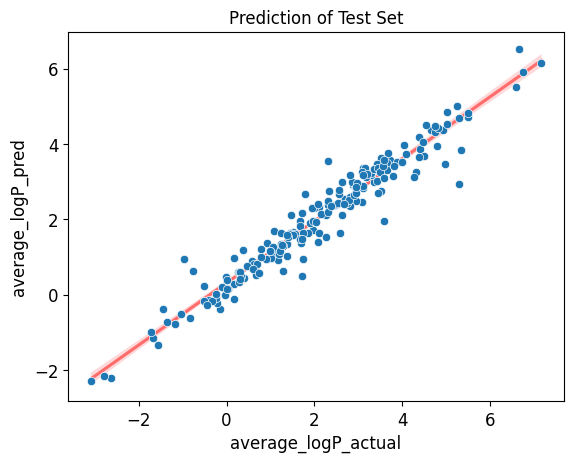

In [42]:
actual_value = pred_df['average_logP_actual']
predicted_value = pred_df['average_logP_pred']
r2 = np.round(r2_score(actual_value, predicted_value), 6)

sns.scatterplot(x='average_logP_actual', y='average_logP_pred', data=pred_df, ax=None,zorder=3)
sns.regplot(x='average_logP_actual', y='average_logP_pred', data=pred_df, scatter=False, color='red', line_kws={'alpha':0.5},ax=None)
plt.title("Prediction of Test Set")
actual_col='average_logP_actual'
pred_col='average_logP_pred'
lims = [pred_df[[actual_col,pred_col]].min().min(), pred_df[[actual_col,pred_col]].max().max()]
margin = (lims[1] - lims[0]) * 0.05

Note: plot_pred_vs_actual_from_df function in the tutorial does not work for general cases without "avg_pKi_actual" as the column.

In [45]:
dataset_key='dataset/curated_logP.csv'
model_dir='dataset'
descriptor_type = 'rdkit_raw'
best_model_dir = 'dataset/logP_models/best_models'
split_uuid = MP.split_dataset()


if not os.path.exists(f'./{best_model_dir}'):
    os.mkdir(f'./{best_model_dir}')
    
if not os.path.exists(f'./{model_dir}'):
    os.mkdir(f'./{model_dir}')

In [46]:
params = {
    "hyperparam": "True",
    "prediction_type": "regression",

    "dataset_key": dataset_key,
    "id_col": "compound_id",
    "smiles_col": "base_rdkit_smiles",
    "response_cols": "average_logP",

    "splitter":"random",
    "split_uuid": split_uuid,
    "previously_split": "True",

    "featurizer": "computed_descriptors",
    "descriptor_type" : descriptor_type,
    "transformers": "True",

    "search_type": "hyperopt",
    "model_type": "RF|10",
    "rfe": "uniformint|8,512",
    "rfd": "uniformint|6,32",
    "rff": "uniformint|8,200",

    "result_dir": f"./{best_model_dir},./{model_dir}"
}
params.update(params)


In [47]:
import atomsci.ddm.utils.hyperparam_search_wrapper as hsw
import importlib
importlib.reload(hsw)
ampl_param = hsw.parse_params(params)
hs = hsw.build_search(ampl_param)
hs.run_search()

model_performance|train_r2|train_rms|valid_r2|valid_rms|test_r2|test_rms|model_params|model

rf_estimators: 332, rf_max_depth: 15, rf_max_feature: 157
num_model_tasks is deprecated and its value is ignored.
RF model with computed_descriptors and rdkit_raw      
model_performance|0.000|100.000|0.000|100.000|0.000|100.000|332_15_157|./dataset/curated_logP_model_5a3de283-2c30-4891-be1b-1850309d6e44.tar.gz

rf_estimators: 209, rf_max_depth: 19, rf_max_feature: 186        
num_model_tasks is deprecated and its value is ignored.          
RF model with computed_descriptors and rdkit_raw                 
model_performance|0.000|100.000|0.000|100.000|0.000|100.000|209_19_186|./dataset/curated_logP_model_de8066e8-b037-4429-8a8d-390c29a36248.tar.gz

rf_estimators: 401, rf_max_depth: 19, rf_max_feature: 37         
num_model_tasks is deprecated and its value is ignored.          
RF model with computed_descriptors and rdkit_raw                 
model_performance|0.000|100.000|0.000|100.000|0.000|

In [48]:
import atomsci.ddm.pipeline.compare_models as cm

result_df = cm.get_filesystem_perf_results(
    result_dir=model_dir,
    pred_type='regression'
)

# sort by validation r2 score to see top performing models
result_df = result_df.sort_values(by='best_valid_r2_score', ascending=False)
result_df[['model_uuid','model_parameters_dict','best_valid_r2_score','best_test_r2_score']]

Found data for 72 models under dataset


,model_uuid,model_parameters_dict,best_valid_r2_score,best_test_r2_score
36,fcd04610-23c1-4b57-9632-55ad08550839,"{""best_epoch"": 80, ""dropouts"": [0.301224732188...",8.592978e-01,8.592978e-01
6,63a3fb43-5c12-453e-ba0d-d63f9d21ac69,"{""rf_estimators"": 500, ""rf_max_depth"": null, ""...",6.787104e-01,7.643426e-01
56,a72ac02a-9a50-4d0e-adb9-70c00afe345f,"{""best_epoch"": 83, ""dropouts"": [0.355307981119...",6.712113e-01,7.632405e-01
38,3b0d6747-bc41-48bb-ade2-e597b5f6b6eb,"{""best_epoch"": 27, ""dropouts"": [0.209300901720...",6.638400e-01,7.607197e-01
32,35ca7828-dc8f-4ae8-bae2-e4f3b6eac471,"{""rf_estimators"": 131, ""rf_max_depth"": 27, ""rf...",6.622355e-01,7.332070e-01
...,...,...,...,...
44,75302db9-a34c-49eb-bb7f-c74e2b6464d3,"{""best_epoch"": 3, ""dropouts"": [0.1402025444526...",-1.741176e-02,-9.504455e-04
50,8e74a4b0-2b58-489c-a26e-0e92da60e7c6,"{""best_epoch"": 0, ""dropouts"": [0.2963568356502...",-2.730957e-02,-3.524436e-03
65,c2a48e5e-3da0-4e66-948f-0ffcfa7eb761,"{""xgb_colsample_bytree"": 1.0, ""xgb_gamma"": 0.0...",-5.616242e-02,5.227506e-02
61,9eac169e-a041-4c4c-8a4a-23cb354d9216,"{""xgb_colsample_bytree"": 1.0, ""xgb_gamma"": 0.0...",-1.392947e+00,-7.737900e-01


In [50]:
import atomsci.ddm.pipeline.compare_models as cm

result_df = cm.get_filesystem_perf_results(
    result_dir=model_dir,
    pred_type='regression'
)

# sort by validation r2 score to see top performing models
result_df = result_df.sort_values(by='best_valid_r2_score', ascending=False)
result_df[['model_uuid','model_parameters_dict','best_valid_r2_score','best_test_r2_score']].head()

Found data for 72 models under dataset


,model_uuid,model_parameters_dict,best_valid_r2_score,best_test_r2_score
36,fcd04610-23c1-4b57-9632-55ad08550839,"{""best_epoch"": 80, ""dropouts"": [0.301224732188...",0.859298,0.859298
6,63a3fb43-5c12-453e-ba0d-d63f9d21ac69,"{""rf_estimators"": 500, ""rf_max_depth"": null, ""...",0.678710,0.764343
56,a72ac02a-9a50-4d0e-adb9-70c00afe345f,"{""best_epoch"": 83, ""dropouts"": [0.355307981119...",0.671211,0.763241
38,3b0d6747-bc41-48bb-ade2-e597b5f6b6eb,"{""best_epoch"": 27, ""dropouts"": [0.209300901720...",0.663840,0.760720
32,35ca7828-dc8f-4ae8-bae2-e4f3b6eac471,"{""rf_estimators"": 131, ""rf_max_depth"": 27, ""rf...",0.662236,0.733207


In [51]:
# NN models

nn_params = {
    "search_type": "hyperopt",
    "model_type": "NN|10",
    "lr": "loguniform|-13.8,-3",
    "ls": "uniformint|3|8,512",
    "dp": "uniform|3|0,0.4",
    "max_epochs":100
}

params.update(nn_params)

import atomsci.ddm.utils.hyperparam_search_wrapper as hsw
import importlib
importlib.reload(hsw)
ampl_param = hsw.parse_params(params)
hs = hsw.build_search(ampl_param)
hs.run_search()

model_performance|train_r2|train_rms|valid_r2|valid_rms|test_r2|test_rms|model_params|model

learning_rate: 0.0007468330179650495, layer_sizes: 262,451,268, dropouts: 0.239592520094438,0.004986042975257599,0.2090928789248149
num_model_tasks is deprecated and its value is ignored.
NN model with computed_descriptors and rdkit_raw      
model_performance|0.000|100.000|0.000|100.000|0.000|100.000|0.0007468330179650495_262,451,268_0.239592520094438,0.004986042975257599,0.2090928789248149|./dataset/curated_logP_model_aacc798e-5e6e-4250-952f-c67737a891ee.tar.gz

learning_rate: 0.006762885501360136, layer_sizes: 320,140,119, dropouts: 0.29030540569752566,0.09628162302268871,0.2592485293663963
num_model_tasks is deprecated and its value is ignored.          
NN model with computed_descriptors and rdkit_raw                 
model_performance|0.000|100.000|0.000|100.000|0.000|100.000|0.006762885501360136_320,140,119_0.29030540569752566,0.09628162302268871,0.2592485293663963|./dataset/curated_logP

In [52]:
# check parameters of best model
result_df["model_parameters_dict"][53]

'{"best_epoch": 11, "dropouts": [0.24973705913310376, 0.307049194015538, 0.26249482688443343], "layer_sizes": [123, 482, 419], "learning_rate": 0.0006512872420318138, "max_epochs": 100}'

In [53]:
import atomsci.ddm.pipeline.compare_models as cm

result_df = cm.get_filesystem_perf_results(
    result_dir=model_dir,
    pred_type='regression'
)

# sort by validation r2 score to see top performing models
result_df = result_df.sort_values(by='best_test_r2_score', ascending=False)
result_df[['model_uuid','model_parameters_dict','best_valid_r2_score','best_test_r2_score','splitter']].head(20)

Found data for 72 models under dataset


,model_uuid,model_parameters_dict,best_valid_r2_score,best_test_r2_score,splitter
36,fcd04610-23c1-4b57-9632-55ad08550839,"{""best_epoch"": 80, ""dropouts"": [0.301224732188...",0.859298,0.859298,scaffold
58,e17ebc12-b946-4f2b-9461-cdc5cdc6e6d3,"{""best_epoch"": 80, ""dropouts"": [0.301224732188...",0.659879,0.776783,scaffold
53,976e6019-233b-4f82-a5f0-13278b52f425,"{""best_epoch"": 11, ""dropouts"": [0.249737059133...",0.643603,0.775382,scaffold
41,f4a80226-e68b-46ef-9450-6e54c48a7890,"{""best_epoch"": 52, ""dropouts"": [0.046622041395...",0.643871,0.773826,scaffold
54,5caacb38-0872-4432-b2b0-b07af04036e3,"{""best_epoch"": 12, ""dropouts"": [0.059574052526...",0.648444,0.773462,scaffold
40,a875e6e5-bf37-43ae-957a-db72ed711824,"{""best_epoch"": 47, ""dropouts"": [0.176388418774...",0.653128,0.770995,scaffold
49,3b331d14-449f-4e49-aadd-2c19561bbcc0,"{""best_epoch"": 95, ""dropouts"": [0.128985421106...",0.632983,0.766224,scaffold
6,63a3fb43-5c12-453e-ba0d-d63f9d21ac69,"{""rf_estimators"": 500, ""rf_max_depth"": null, ""...",0.678710,0.764343,scaffold
56,a72ac02a-9a50-4d0e-adb9-70c00afe345f,"{""best_epoch"": 83, ""dropouts"": [0.355307981119...",0.671211,0.763241,scaffold
55,0f86d7ac-1e9e-463d-aa30-d994b90ea1f0,"{""best_epoch"": 18, ""dropouts"": [0.314249341386...",0.656786,0.761674,scaffold


In [54]:
# xgboost models
xg_params = {
    "search_type": "hyperopt",
    "model_type": "xgboost|10",
    "xgbg": "uniform|0,0.2",
    "xgbl": "loguniform|-2,2",
}

params.update(xg_params)

ampl_param = hsw.parse_params(params)
hs = hsw.build_search(ampl_param)
hs.run_search()

model_performance|train_r2|train_rms|valid_r2|valid_rms|test_r2|test_rms|model_params|model

xgb_gamma: 0.06656189285257368, xgb_learning_rate: 0.5422851381923894, xgb_max_depth: 6, xgb_colsample_bytree: 1.0, xgb_subsample: 1.0, xgb_n_estimators: 100, xgb_min_child_weight: 1.0
num_model_tasks is deprecated and its value is ignored.
xgboost model with computed_descriptors and rdkit_raw 
model_performance|0.000|100.000|0.000|100.000|0.000|100.000|0.06656189285257368_0.5422851381923894_6_1.0_1.0_100_1.0|./dataset/curated_logP_model_3b10fb90-6427-4c6e-8397-077ce06ec592.tar.gz

xgb_gamma: 0.17754039888374196, xgb_learning_rate: 0.8377172050444304, xgb_max_depth: 6, xgb_colsample_bytree: 1.0, xgb_subsample: 1.0, xgb_n_estimators: 100, xgb_min_child_weight: 1.0
num_model_tasks is deprecated and its value is ignored.          
xgboost model with computed_descriptors and rdkit_raw            
model_performance|0.000|100.000|0.000|100.000|0.000|100.000|0.17754039888374196_0.8377172050444304_6_1.

In [57]:
import atomsci.ddm.pipeline.compare_models as cm

result_df = cm.get_filesystem_perf_results(
    result_dir=model_dir,
    pred_type='regression'
)

# sort by test r2 score to see top performing models
result_df = result_df.sort_values(by='best_test_r2_score', ascending=False)
result_df[['model_uuid','model_parameters_dict','best_valid_r2_score','best_test_r2_score']]

Found data for 72 models under dataset


,model_uuid,model_parameters_dict,best_valid_r2_score,best_test_r2_score
36,fcd04610-23c1-4b57-9632-55ad08550839,"{""best_epoch"": 80, ""dropouts"": [0.301224732188...",8.592978e-01,8.592978e-01
58,e17ebc12-b946-4f2b-9461-cdc5cdc6e6d3,"{""best_epoch"": 80, ""dropouts"": [0.301224732188...",6.598788e-01,7.767834e-01
53,976e6019-233b-4f82-a5f0-13278b52f425,"{""best_epoch"": 11, ""dropouts"": [0.249737059133...",6.436030e-01,7.753817e-01
41,f4a80226-e68b-46ef-9450-6e54c48a7890,"{""best_epoch"": 52, ""dropouts"": [0.046622041395...",6.438705e-01,7.738258e-01
54,5caacb38-0872-4432-b2b0-b07af04036e3,"{""best_epoch"": 12, ""dropouts"": [0.059574052526...",6.484440e-01,7.734624e-01
...,...,...,...,...
44,75302db9-a34c-49eb-bb7f-c74e2b6464d3,"{""best_epoch"": 3, ""dropouts"": [0.1402025444526...",-1.741176e-02,-9.504455e-04
48,2f05b123-b778-47ca-9645-d1efba75f8cd,"{""best_epoch"": 0, ""dropouts"": [0.3276626047671...",3.308598e-03,-2.814444e-03
50,8e74a4b0-2b58-489c-a26e-0e92da60e7c6,"{""best_epoch"": 0, ""dropouts"": [0.2963568356502...",-2.730957e-02,-3.524436e-03
61,9eac169e-a041-4c4c-8a4a-23cb354d9216,"{""xgb_colsample_bytree"": 1.0, ""xgb_gamma"": 0.0...",-1.392947e+00,-7.737900e-01


In [61]:
# fingerprint split models - use Tutorial 3 to create a fingerprint split
fp_split_uuid="be60c264-6ac0-4841-a6b6-41bf846e4ae4"

fp_params = {
    "splitter":"fingerprint",
    "split_uuid": fp_split_uuid,
    "previously_split": "True",
}

In [62]:
# Morgan fingerprint features
ecfp_params = {
    "featurizer": "ecfp",
    "ecfp_radius" : 2,
    "ecfp_size" : 1024,
    "transformers": "True",
}

In [63]:
import atomsci.ddm.pipeline.compare_models as cm

result_df = cm.get_filesystem_perf_results(
    result_dir=model_dir,
    pred_type='regression'
)

# sort by validation r2 score to see top performing models
result_df = result_df.sort_values(by='best_valid_r2_score', ascending=False)
result_df[['model_uuid','model_parameters_dict','best_valid_r2_score','best_test_r2_score']].head()

Found data for 72 models under dataset


,model_uuid,model_parameters_dict,best_valid_r2_score,best_test_r2_score
36,fcd04610-23c1-4b57-9632-55ad08550839,"{""best_epoch"": 80, ""dropouts"": [0.301224732188...",0.859298,0.859298
6,63a3fb43-5c12-453e-ba0d-d63f9d21ac69,"{""rf_estimators"": 500, ""rf_max_depth"": null, ""...",0.678710,0.764343
56,a72ac02a-9a50-4d0e-adb9-70c00afe345f,"{""best_epoch"": 83, ""dropouts"": [0.355307981119...",0.671211,0.763241
38,3b0d6747-bc41-48bb-ade2-e597b5f6b6eb,"{""best_epoch"": 27, ""dropouts"": [0.209300901720...",0.663840,0.760720
32,35ca7828-dc8f-4ae8-bae2-e4f3b6eac471,"{""rf_estimators"": 131, ""rf_max_depth"": 27, ""rf...",0.662236,0.733207


# Compare models

In [64]:
result_df

,model_uuid,model_path,ampl_version,model_type,dataset_key,features,splitter,split_strategy,model_score_type,feature_transform_type,...,dropouts,xgb_gamma,xgb_learning_rate,xgb_max_depth,xgb_colsample_bytree,xgb_subsample,xgb_n_estimators,xgb_min_child_weight,model_parameters_dict,feat_parameters_dict
36,fcd04610-23c1-4b57-9632-55ad08550839,dataset/curated_logP_model_fcd04610-23c1-4b57-...,1.6.0,NN,/home/jupyter/AMPL/atomsci/logP/dataset/curate...,rdkit_raw,scaffold,train_valid_test,r2,normalization,...,"0.30,0.15,0.13",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 80, ""dropouts"": [0.301224732188...",{}
6,63a3fb43-5c12-453e-ba0d-d63f9d21ac69,dataset/curated_logP_model_63a3fb43-5c12-453e-...,1.6.0,RF,/home/jupyter/AMPL/atomsci/logP/dataset/curate...,rdkit_raw,scaffold,train_valid_test,r2,normalization,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 500, ""rf_max_depth"": null, ""...",{}
56,a72ac02a-9a50-4d0e-adb9-70c00afe345f,dataset/curated_logP_model_a72ac02a-9a50-4d0e-...,1.6.0,NN,/home/jupyter/AMPL/atomsci/logP/dataset/curate...,rdkit_raw,scaffold,train_valid_test,r2,normalization,...,"0.36,0.14,0.26",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 83, ""dropouts"": [0.355307981119...",{}
38,3b0d6747-bc41-48bb-ade2-e597b5f6b6eb,dataset/curated_logP_model_3b0d6747-bc41-48bb-...,1.6.0,NN,/home/jupyter/AMPL/atomsci/logP/dataset/curate...,rdkit_raw,scaffold,train_valid_test,r2,normalization,...,"0.21,0.01,0.25",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 27, ""dropouts"": [0.209300901720...",{}
32,35ca7828-dc8f-4ae8-bae2-e4f3b6eac471,dataset/curated_logP_model_35ca7828-dc8f-4ae8-...,1.6.0,RF,/home/jupyter/AMPL/atomsci/logP/dataset/curate...,rdkit_raw,scaffold,train_valid_test,r2,normalization,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 131, ""rf_max_depth"": 27, ""rf...",{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,75302db9-a34c-49eb-bb7f-c74e2b6464d3,dataset/curated_logP_model_75302db9-a34c-49eb-...,1.6.0,NN,/home/jupyter/AMPL/atomsci/logP/dataset/curate...,rdkit_raw,scaffold,train_valid_test,r2,normalization,...,"0.14,0.24,0.22",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 3, ""dropouts"": [0.1402025444526...",{}
50,8e74a4b0-2b58-489c-a26e-0e92da60e7c6,dataset/curated_logP_model_8e74a4b0-2b58-489c-...,1.6.0,NN,/home/jupyter/AMPL/atomsci/logP/dataset/curate...,rdkit_raw,scaffold,train_valid_test,r2,normalization,...,"0.30,0.35,0.09",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 0, ""dropouts"": [0.2963568356502...",{}
65,c2a48e5e-3da0-4e66-948f-0ffcfa7eb761,dataset/curated_logP_model_c2a48e5e-3da0-4e66-...,1.6.0,xgboost,/home/jupyter/AMPL/atomsci/logP/dataset/curate...,rdkit_raw,scaffold,train_valid_test,r2,normalization,...,NaN,0.017394,1.556241,6.0,1.0,1.0,100.0,1.0,"{""xgb_colsample_bytree"": 1.0, ""xgb_gamma"": 0.0...",{}
61,9eac169e-a041-4c4c-8a4a-23cb354d9216,dataset/curated_logP_model_9eac169e-a041-4c4c-...,1.6.0,xgboost,/home/jupyter/AMPL/atomsci/logP/dataset/curate...,rdkit_raw,scaffold,train_valid_test,r2,normalization,...,NaN,0.050773,1.938238,6.0,1.0,1.0,100.0,1.0,"{""xgb_colsample_bytree"": 1.0, ""xgb_gamma"": 0.0...",{}


In [65]:
#  model counts
# 72 total
model_counts=pd.DataFrame(result_df.groupby(['features','splitter','model_type'])['model_uuid'].count()).reset_index()
model_counts=model_counts.pivot(index='model_type',columns=['splitter','features',], values='model_uuid')
model_counts

splitter,scaffold
features,rdkit_raw
model_type,
NN,26
RF,33
xgboost,13


# Production Model

In [67]:
import pandas as pd
import os
from atomsci.ddm.utils import model_retrain as mr
from atomsci.ddm.utils import model_version_utils as mv
from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import predict_from_model as pfm
from atomsci.ddm.pipeline import perf_plots as pp
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [68]:
winnertype='best_test_r2_score'
result_df = cm.get_filesystem_perf_results(
    result_dir=model_dir,
    pred_type='regression'
)
#result_df=pd.read_csv('dataset/SLC6A3_models/07_example_pred_df.csv', index_col=0)
result_df=result_df.sort_values(winnertype, ascending=False)

Found data for 72 models under dataset


In [71]:
result_df.iloc[0].model_parameters_dict

'{"best_epoch": 80, "dropouts": [0.30122473218859236, 0.1473385547373891, 0.12542010073561682], "layer_sizes": [333, 379, 305], "learning_rate": 0.00010901598351662521, "max_epochs": 81}'

In [72]:
result_df.iloc[0].model_path

'dataset/curated_logP_model_fcd04610-23c1-4b57-9632-55ad08550839.tar.gz'

'dataset/curated_logP_model_fcd04610-23c1-4b57-9632-55ad08550839.tar.gz'

In [73]:
#Tutorial 7 RF saved model_path
best_model_path='dataset/curated_logP_model_fcd04610-23c1-4b57-9632-55ad08550839.tar.gz'

#get installed AMPL version
print("installed AMPL version: " + str(mv.get_ampl_version()))

#get AMPL model version
print("best model AMPL version: " + str(mv.get_ampl_version_from_model(best_model_path)))

# check versions are compatible
assert(mv.check_version_compatible(best_model_path))

#load best model production params
best_model_pipe = mp.create_prediction_pipeline_from_file(params=None, reload_dir=None, model_path=best_model_path, model_type='best_model', featurization=None, verbose=False)

#show production is false
print("orig_params.production: " + str(best_model_pipe.orig_params.production))

INFO:atomsci.ddm.utils.model_version_utils:dataset/curated_logP_model_fcd04610-23c1-4b57-9632-55ad08550839.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:dataset/curated_logP_model_fcd04610-23c1-4b57-9632-55ad08550839.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: dataset/curated_logP_model_fcd04610-23c1-4b57-9632-55ad08550839.tar.gz version = "1.6", AMPL version = "1.6"


installed AMPL version: 1.6.0
best model AMPL version: 1.6.0


INFO:atomsci.ddm.utils.model_version_utils:dataset/curated_logP_model_fcd04610-23c1-4b57-9632-55ad08550839.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: dataset/curated_logP_model_fcd04610-23c1-4b57-9632-55ad08550839.tar.gz version = "1.6", AMPL version = "1.6"


num_model_tasks is deprecated and its value is ignored.
['/var/tmp/tmp8z47nzwe/best_model/checkpoint1.pt']
/var/tmp/tmp8z47nzwe/best_model/checkpoint1.pt
orig_params.production: True


In [74]:
odir='dataset'

production_model = mr.train_model_from_tar(input=best_model_path, output=odir, production=True)

#check for parameters
print("production_model.params.production: " + str(production_model.params.production))
print("production_model.params.model_tarball_path: " + str(production_model.params.model_tarball_path))

print("production model AMPL version: " + str(mv.get_ampl_version_from_model(production_model.params.model_tarball_path)))

num_model_tasks is deprecated and its value is ignored.


/home/jupyter/AMPL/atomsci/ddm/pipeline/transformations.py:250: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)


['dataset/curated_logP/NN_computed_descriptors_scaffold_regression/9eaed48b-9b97-4770-9237-66f7eafcebe9/model/checkpoint1.pt', 'dataset/curated_logP/NN_computed_descriptors_scaffold_regression/9eaed48b-9b97-4770-9237-66f7eafcebe9/model/checkpoint2.pt', 'dataset/curated_logP/NN_computed_descriptors_scaffold_regression/9eaed48b-9b97-4770-9237-66f7eafcebe9/model/checkpoint3.pt', 'dataset/curated_logP/NN_computed_descriptors_scaffold_regression/9eaed48b-9b97-4770-9237-66f7eafcebe9/model/checkpoint4.pt', 'dataset/curated_logP/NN_computed_descriptors_scaffold_regression/9eaed48b-9b97-4770-9237-66f7eafcebe9/model/checkpoint5.pt']
dataset/curated_logP/NN_computed_descriptors_scaffold_regression/9eaed48b-9b97-4770-9237-66f7eafcebe9/model/checkpoint1.pt


INFO:atomsci.ddm.utils.model_version_utils:dataset/curated_logP_model_9eaed48b-9b97-4770-9237-66f7eafcebe9.tar.gz, 1.6.0


production_model.params.production: True
production_model.params.model_tarball_path: dataset/curated_logP_model_9eaed48b-9b97-4770-9237-66f7eafcebe9.tar.gz
production model AMPL version: 1.6.0


In [ ]:
test_file_path = 'dataset/full_dataset.csv'
test_data = pd.read_csv(test_file_path)

test_data.head()

In [ ]:
test_data['base_rdkit_smiles'] = base_smiles_from_smiles(test_data.smiles.tolist(), workers=8)

In [ ]:

smiles_col = 'base_rdkit_smiles'
response_col = 'LogP'

best_pred_df = pfm.predict_from_model_file(model_path = best_model_path, 
                                      input_df = test_data,
                                      smiles_col = smiles_col, 
                                      response_col = response_col,
                                      is_featurized=False) 
                                      
best_pred_df.head()

In [ ]:
prod_pred_df = pfm.predict_from_model_file(model_path = production_model.params.model_tarball_path, 
                                      input_df = test_data,
                                      smiles_col = smiles_col, 
                                      response_col = response_col,
                                      is_featurized=False)
                                      
prod_pred_df.head()

In [ ]:
best_r2 = np.round(r2_score(best_pred_df.average_logP_pred.values, best_pred_df.average_logP_actual.values), 6)
prod_r2 = np.round(r2_score(prod_pred_df.LogP_pred.values, prod_pred_df.LogP_actual.values), 6)
print("Best model r2_score: " + str(best_r2))
print("Production model r2_score: " + str(prod_r2))

# Try Classification

In [ ]:
curated_logPclass = pd.read_csv("dataset/curated_logP.csv")

In [ ]:
#curated_logPclass['logP_level'] = pd.cut(curated_logPclass['average_logP'], bins=[-float('inf'), 2, 4, float('inf')],
 #                             labels=['poor', 'medium', 'good'], right=False)
curated_logPclass['logP_level'] = pd.cut(curated_logPclass['average_logP'], bins=[-float('inf'), 2, 4, float('inf')],
                              labels=[0,1,2], right=False)

In [ ]:
curated_logPclass['logP_level'] = pd.cut(curated_logPclass['average_logP'], bins=[-float('inf'), 3.5, float('inf')],
                              labels=[0,1], right=False)

In [ ]:
curated_logPclass

In [ ]:
curated_logPclass.to_csv('dataset/curated_logPclass.csv', index=False)

In [ ]:
curated_logPclass["logP_level"]

In [ ]:

#dataset_key='dataset/curated_logP.csv'
dataset_key='dataset/curated_logPclass.csv'
model_dir='dataset'
descriptor_type = 'rdkit_raw'
best_model_dir = 'dataset/logP_models/best_models'
split_uuid = MP.split_dataset()


if not os.path.exists(f'./{best_model_dir}'):
    os.mkdir(f'./{best_model_dir}')
    
if not os.path.exists(f'./{model_dir}'):
    os.mkdir(f'./{model_dir}')

In [ ]:
import pandas as pd
from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse

dataset_file = 'dataset/curated_logPclass.csv'
odir='dataset'

response_col = "logP_level"
compound_id = "compound_id"
smiles_col = "base_rdkit_smiles"
#split_uuid = "c35aeaab-910c-4dcf-8f9f-04b55179aa1a"

params = {
        "verbose": "True",
        "system": "LC",
        "datastore": "False",
        "save_results": "False",
        "prediction_type": "classification",
        "dataset_key": dataset_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "previously_split": "True",
        "split_uuid" : split_uuid,
        "split_only": "False",
        "featurizer": "computed_descriptors",
        "descriptor_type" : "rdkit_raw",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        "rerun": "False",
        "result_dir": odir
    }

ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

In [ ]:
split_uuid

In [ ]:
from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse

pparams = parse.wrapper(params)
MP = mp.ModelPipeline(pparams)
split_uuid = MP.split_dataset()

In [ ]:
params = {
    "hyperparam": "True",
    "prediction_type": "classification",

    "dataset_key": 'dataset/curated_logPclass.csv',
    "id_col": "compound_id",
    "smiles_col": "base_rdkit_smiles",
    "response_cols": "logP_level",

    "splitter":"scaffold",
    "split_uuid": split_uuid,
    "previously_split": "True",

    "featurizer": "computed_descriptors",
    "descriptor_type" : descriptor_type,
    "transformers": "True",

    "search_type": "hyperopt",
    "model_type": "RF|10",
    "rfe": "uniformint|8,512",
    "rfd": "uniformint|6,32",
    "rff": "uniformint|8,200",

    "result_dir": f"./{best_model_dir},./{model_dir}"
}

In [ ]:
import atomsci.ddm.utils.hyperparam_search_wrapper as hsw
import importlib
importlib.reload(hsw)
ampl_param = hsw.parse_params(params)
hs = hsw.build_search(ampl_param)
hs.run_search()

In [ ]:
# Model Performance
from atomsci.ddm.pipeline import compare_models as cm
class_pred_df = cm.get_filesystem_perf_results(odir, pred_type='classification')

In [ ]:
import atomsci.ddm.pipeline.compare_models as cm

result_df = cm.get_filesystem_perf_results(
    result_dir=model_dir,
    pred_type='classification'
)

# sort by validation r2 score to see top performing models
result_df.head()
#result_df = result

_df.sort_values(by='best_valid_r2_score', ascending=False)
#result_df[['model_uuid','model_parameters_dict','best_valid_r2_score','best_test_r2_score']].head()